In [1]:
# %%
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
from os.path import join
import re
import math
import time
import glob
import pickle as pkl
from PIL import Image
import numpy as np
import pandas as pd
from easydict import EasyDict as edict
import h5py
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from neuro_data_analysis.mat_data_translate_lib import h5_to_dict_simplify, print_hdf5_info
from neuro_data_analysis.neural_tuning_analysis_lib import organize_unit_info, maybe_add_unit_id_to_meta, \
    calculate_neural_responses, parse_stim_info, find_full_image_paths, load_space_images
from core.utils.plot_utils import saveallforms
from core.utils.colormap_matlab import parula, viridis
from core.utils.montage_utils import PIL_array_to_montage, PIL_array_to_montage_score_frame
from core.utils.dataset_utils import ImagePathDataset
# set the pandas display options width
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

mat_root = r"S:\Data-Ephys-MAT"
pkl_root = r"S:\Data-Ephys-PKL"
exp_record_pathdict = {"Alfa": r"S:\Exp_Record_Alfa.xlsx", 
                       "Beto": r"S:\ExpSpecTable_Augment.xlsx",
                       "Caos": r"S:\Exp_Record_Caos.xlsx",
                       "Diablito": r"S:\Exp_Record_Diablito.xlsx"}

#%% Main analysis pipeline

c:\Users\ponce\.conda\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ExpRecord_Hessian_All = pd.read_csv(r"ExpRecord_BigGAN_Hessian_tuning_ABCD_w_meta.csv")
ExpRecord_Evol_All = pd.read_csv(r"ExpRecord_BigGAN_Hessian_Evol_ABCD_w_meta.csv")
figroot = f"E:\OneDrive - Harvard University\BigGAN_Hessian"

In [4]:
for _, exprow in ExpRecord_Hessian_All.iterrows():
    print(exprow.ephysFN,exprow.Expi)
    data = pkl.load(open(join(pkl_root, f"{exprow.ephysFN}.pkl"), "rb"))
    rasters = data["rasters"]
    meta = data["meta"]
    Trials = data["Trials"]
    imageName = np.squeeze(Trials.imageName)
    stimuli_dir = exprow.stimuli
    stimuli_dir = stimuli_dir.replace("N:", "S:")
    break


Caos-12022024-003 1.0


In [72]:
rasters.shape

(798, 200, 120)

### Make matched dataset, move Hess_mat.npz to stimuli_dir/summary

In [216]:
import shutil
# for ExpRecord_Hessian_All each row, find the corresponding Expi and Animal in ExpRecord_Evol_All
for _, exprow in ExpRecord_Hessian_All.iterrows():

    exprow_evol = ExpRecord_Evol_All.query("Expi == @exprow.Expi and Animal == @exprow.Animal")
    if len(exprow_evol) == 0:
        print(f"No corresponding row found for {exprow.ephysFN} {exprow.Expi} {exprow.Animal}")
        continue
    exprow_evol = exprow_evol.iloc[0]
    # print(exprow_evol)
    stimuli_dir_hess = exprow.stimuli
    stimuli_dir_hess = stimuli_dir_hess.replace("N:", "S:")
    stimuli_dir_evol = exprow_evol.stimuli
    stimuli_dir_evol = stimuli_dir_evol.replace("N:", "S:")
    # copy Hess_mat.npz to stimuli_dir/summary
    # assert os.path.exists(join(stimuli_dir_hess, "summary", f"noise_ImDist_root_data.npz"))
    if not os.path.exists(join(stimuli_dir_evol, "Hess_imgs", "summary", f"noise_ImDist_root_data.npz")):
        print(f"no noise data for {exprow_evol.ephysFN} {exprow_evol.Expi} {exprow_evol.Animal} {stimuli_dir_evol}")
        continue
    if not os.path.exists(join(stimuli_dir_evol, "Hess_imgs", "summary", f"class_ImDist_root_data.npz")):
        print(f"no class data for {exprow_evol.ephysFN} {exprow_evol.Expi} {exprow_evol.Animal} {stimuli_dir_evol}")
        continue
    # copy the summary folder to stimuli_dir_hess
    if not os.path.exists(join(stimuli_dir_hess, "summary")):
        shutil.copytree(join(stimuli_dir_evol, "Hess_imgs", "summary"), join(stimuli_dir_hess, "summary"))
    else:
        print(f"summary folder already exists for {exprow_evol.ephysFN} {exprow_evol.Expi} {exprow_evol.Animal} {stimuli_dir_hess}")
        assert os.path.exists(join(stimuli_dir_hess, "summary", f"class_ImDist_root_data.npz"))
        assert os.path.exists(join(stimuli_dir_hess, "summary", f"noise_ImDist_root_data.npz"))


summary folder already exists for Caos-12022024-002 1.0 Caos S:\Stimuli\Evolutions\2024\2024-12-02-Ev-Caos-01\2024-12-02-14-39-44\Hess_imgs
summary folder already exists for Caos-12022024-005 2.0 Caos S:\Stimuli\Evolutions\2024\2024-12-02-Ev-Caos-03\2024-12-02-15-39-42\Hess_imgs
summary folder already exists for Caos-12042024-002 3.0 Caos S:\Stimuli\Evolutions\2024\2024-12-04-Ev-Caos-01\2024-12-04-14-18-16\Hess_imgs
summary folder already exists for Caos-12042024-006 4.0 Caos S:\Stimuli\Evolutions\2024\2024-12-04-Ev-Caos-02\2024-12-04-15-11-33\Hess_imgs
summary folder already exists for Caos-12092024-003 5.0 Caos S:\Stimuli\Evolutions\2024\2024-12-09-Ev-Caos-02\2024-12-09-14-23-19\Hess_imgs
summary folder already exists for Caos-12102024-002 6.0 Caos S:\Stimuli\Evolutions\2024\2024-12-10-Ev-Caos-01\2024-12-10-13-16-26\Hess_imgs
summary folder already exists for Caos-12102024-005 7.0 Caos S:\Stimuli\Evolutions\2024\2024-12-10-Ev-Caos-03\2024-12-10-14-17-59\Hess_imgs
summary folder alrea

### Latent code meta data load

In [18]:
stimuli_dir

'S:\\Stimuli\\Evolutions\\2024\\2024-12-02-Ev-Caos-01\\2024-12-02-14-39-44\\Hess_imgs'

In [19]:
data = np.load(join(stimuli_dir, "summary", "Hess_mat.npz"))
print([*data])
for k in data.keys():
    print(k, data[k].shape)

['H_clas', 'eigvals_clas', 'eigvects_clas', 'H_nois', 'eigvals_nois', 'eigvects_nois', 'vect', 'noisevec', 'classvec']
H_clas (128, 128)
eigvals_clas (128,)
eigvects_clas (128, 128)
H_nois (128, 128)
eigvals_nois (128,)
eigvects_nois (128, 128)
vect (1, 256)
noisevec (1, 128)
classvec (1, 128)


In [32]:
data = np.load(join(stimuli_dir, "summary", "class_ImDist_root_data.npz"))
print([*data])
for k in data.keys():
    print(k, data[k].shape)

['xtick_arr', 'dsim_arr', 'vecs_arr', 'targ_val', 'eiglist']
xtick_arr (10, 9)
dsim_arr (10, 9)
vecs_arr (10, 9, 256)
targ_val (4,)
eiglist (10,)


In [ ]:
data = np.load(join(stimuli_dir, "summary", "noise_ImDist_root_data.npz"))
print([*data])
for k in data.keys():
    print(k, data[k].shape) 

['xtick_arr', 'dsim_arr', 'vecs_arr', 'targ_val', 'eiglist']
xtick_arr (9, 9)
dsim_arr (9, 9)
vecs_arr (9, 9, 256)
targ_val (4,)
eiglist (9,)


In [ ]:
import pandas as pd
df_both = []
for space_name in ["noise", "class"]:
    data = np.load(join(stimuli_dir, "summary", f"{space_name}_ImDist_root_data.npz"))
    # Assuming data is already loaded as shown in the previous cells
    xtick_arr = data["xtick_arr"]
    dsim_arr = data["dsim_arr"]
    vecs_arr = data["vecs_arr"]
    eiglist = data["eiglist"]   
    targ_val = data["targ_val"]
    target_val_arr = [*(-targ_val[::-1]), 0, *targ_val]
    assert xtick_arr.shape[1] == len(target_val_arr)
    vecs_flattened = vecs_arr.reshape(-1, vecs_arr.shape[-1])
    # check the first 128 dimensions of vecs_flattened are close to each other
    share_mask = {"noise": slice(128, 256), "class": slice(0, 128)}[space_name]
    assert np.all(vecs_flattened[:, share_mask] == vecs_flattened[0:1, share_mask])
    # Create a DataFrame to organize the data into a table
    table_data = []
    for i in range(xtick_arr.shape[0]):
        for j in range(xtick_arr.shape[1]):
            row = {
                "xtick": xtick_arr[i, j],
                "dsim_actual": dsim_arr[i, j],
                "dsim_target": target_val_arr[j],
                "eig_id": eiglist[i],
                "space_name": space_name,
                "vec": vecs_arr[i, j, :], # .tolist()
            }
            table_data.append(row)

    df = pd.DataFrame(table_data)
    df_both.append(df)
    print(f"{space_name} space data shape =", df.shape)
    # check the column of dsim_actual and dsim_target are close to each other
    print(f"{space_name} space maximal deviation of dsim_actual and dsim_target =", np.max(np.abs(df["dsim_actual"] - np.abs(df["dsim_target"]))))
    # assert np.allclose(df["dsim_actual"], np.abs(df["dsim_target"]), atol=5e-3)

df_both = pd.concat(df_both)
# df_both.to_csv(join(stimuli_dir, "summary", "Hess_ImDist_root_data.csv"), index=False)

noise space data shape = (81, 6)
noise space maximal deviation of dsim_actual and dsim_target = 0.00649564862251284
class space data shape = (90, 6)
class space maximal deviation of dsim_actual and dsim_target = 0.0009718310832977362


#### Compute NCSNR

In [168]:
import pandas as pd
import numpy as np
from scipy.stats import zscore

def compute_ncsnr_from_df(
    df,
    stim_var_name='image',
    resp_var_name='beta',
    drop_singles=True

):
    """
    Compute noise-ceiling SNR (ncsnr) from a long-format DataFrame of responses.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must contain at least:
          - a column (image_col) that identifies each stimulus image
          - a column (response_col) that contains the response/beta
            for each trial.
    image_col : str
        Name of the column identifying the image/stimulus.
    response_col : str
        Name of the column containing single-trial responses/betas.
    drop_singles : bool
        If True, drop any images that have only a single trial (because
        variance cannot be estimated for those). If False, those images
        will produce NaN variance and will be included in the mean anyway.

    Returns
    -------
    ncsnr : float
        Noise ceiling SNR (sigma_signal / sigma_noise).
        NaN if sigma_noise = 0, or if there is no valid data.
    """

    # 1) Z-score all responses in the entire DataFrame
    #    (so the overall variance is normalized to 1)
    df = df.copy()  # don't modify the original
    df['zscore_resp'] = zscore(df[resp_var_name].values, ddof=1)
    # 2) Group by image, compute the variance of z-scored responses for each image
    group_var = df.groupby(stim_var_name)['zscore_resp'].var(ddof=1)

    # Optionally drop images that have only one trial (var = NaN)
    if drop_singles:
        group_var = group_var.dropna()
    # If after dropping we have no data, return NaN
    if len(group_var) == 0:
        return np.nan

    # 3) Mean of the per-image variances -> sigma_noise^2
    mean_var = group_var.mean()

    # 4) Noise std dev
    sigma_noise = np.sqrt(mean_var)

    # 5) Signal std dev = sqrt(max(0, 1 - sigma_noise^2))
    sigma_signal = np.sqrt(max(0, 1.0 - sigma_noise**2))

    # 6) ncsnr = sigma_signal / sigma_noise
    if sigma_noise == 0:
        return np.nan
    ncsnr = sigma_signal / sigma_noise
    return ncsnr


def noise_ceiling_percent(ncsnr, n_trials=1):
    """
    Convert ncsnr to the noise ceiling percentage
    (amount of total variance that is explainable signal).


    Formula from the excerpt:
        NC = 100 * sigma_signal^2 / (sigma_signal^2 + sigma_noise^2)
    where ncsnr = sigma_signal / sigma_noise.

    => NC = 100 * (ncsnr^2) / (ncsnr^2 + 1 / n) #NOTE: this is wrong, need 1/n 
    """
    if not np.isfinite(ncsnr):
        return np.nan
    return 100.0 * (ncsnr**2) / (ncsnr**2 + 1.0 / n_trials) 


In [169]:
import numpy as np
import xarray as xr

def compute_noise_ceiling(data_in):
    """
    Compute the noise ceiling signal-to-noise ratio (SNR) and percentage noise ceiling for each unit.
    
    Parameters:
    ----------
    data_in : np.ndarray
        A 3D array of shape (units/voxels, conditions, trials), representing the data for which to compute 
        the noise ceiling. Each unit requires more than 1 trial for each condition.

    Returns:
    -------
    noiseceiling : np.ndarray
        The noise ceiling for each unit, expressed as a percentage.
    ncsnr : np.ndarray
        The noise ceiling signal-to-noise ratio (SNR) for each unit.
    signalvar : np.ndarray
        The signal variance for each unit.
    noisevar : np.ndarray
        The noise variance for each unit.
    """
    # noisevar: mean variance across trials for each unit
    noisevar = np.mean(np.std(data_in, axis=2, ddof=1) ** 2, axis=1)

    # datavar: variance of the trial means across conditions for each unit
    datavar = np.std(np.mean(data_in, axis=2), axis=1, ddof=1) ** 2

    # signalvar: signal variance, obtained by subtracting noise variance from data variance
    signalvar = np.maximum(datavar - noisevar / data_in.shape[2], 0)  # Ensure non-negative variance

    # ncsnr: signal-to-noise ratio (SNR) for each unit
    ncsnr = np.sqrt(signalvar) / np.sqrt(noisevar)

    # noiseceiling: percentage noise ceiling based on SNR
    noiseceiling = 100 * (ncsnr ** 2 / (ncsnr ** 2 + 1 / data_in.shape[2]))

    return noiseceiling, ncsnr, signalvar, noisevar


def get_ncsnr(resps, img_id, uimgid, nreps = 2):
    '''
        Calculate Noise Ceiling using methods of NSD paper.
          - If conditions have vastly different numbers of repeats, then use the minimum.
              (i.e. the num repeats of the condition with the fewest repeats).

        Arguments:
          - resps: (size: num_trials x num_channels) matrix of responses (prior to trial-averaging).
          - img_id: (length: num_trials) vector of image id shown on each trial.
          - uimgid: (length: num_images) vector of all unique images.
    '''
    arr = xr.DataArray(resps, dims = ('presentation', 'channel'), coords={'image_id': ('presentation', img_id)})
    num_reps = arr.groupby('image_id').count().loc[{'image_id': uimgid}].data[:,0]

    # Exclude conditions with less than 2 trials
    valid_uimgid = uimgid[num_reps >= nreps]
    num_reps_valid = num_reps[num_reps >= nreps]
    
    # Use only the minimum number of repeats for all conditions for fairness.
    # (i.e. if some conditions have more repeats, subsample trials)
    min_trials = np.min(num_reps_valid)

    def trim_trials(da, min_trials):
        return da.isel(presentation=np.random.choice(da.image_id.size, min_trials, replace=False))

    arr_trim = arr.sel(presentation=arr['image_id'].isin(valid_uimgid)).groupby('image_id').apply(trim_trials, min_trials=min_trials)
    
    # Noise variance is the variance across repetitions
    noise_sd = np.sqrt(np.mean(np.power(arr_trim.groupby('image_id').std(ddof=1).loc[{'image_id': valid_uimgid}].data, 2), axis=0))
    
    # Total variance is variance across all trials
    total_var = np.power(np.std(resps, axis=0), 2)
    
    # Calculate signal variance by total variance minus noise variance.
    signal_var = total_var - np.power(noise_sd,2)
    signal_var = np.maximum(0, signal_var) # rectification
    signal_sd = np.sqrt(signal_var)
    
    # NCSNR is ratio is signal SD to noise SD.
    ncsnr = signal_sd / noise_sd
    noise_ceiling = 100*(np.power(ncsnr,2) / (np.power(ncsnr,2)+(1/min_trials)))

    return noise_sd, total_var, signal_var, ncsnr, noise_ceiling

In [ ]:
resp_wdw = slice(50, 200)
bsl_wdw = slice(0, 45)
bsl_mat = rasters[:, bsl_wdw, :].mean(axis=1)
resp_mat = rasters[:, resp_wdw, :].mean(axis=1) # average over time

In [ ]:
unit_meta = []
for chani in range(resp_mat.shape[1]):
    df = pd.DataFrame({"img_name": imageName, "unit_response": resp_mat[:, chani], "unit_baseline": bsl_mat[:, chani]})
    ncsnr = compute_ncsnr_from_df(df, stim_var_name="img_name", resp_var_name="unit_response")
    tval, pval = stats.ttest_rel(df["unit_response"], df["unit_baseline"])
    unit_meta.append({"chani": chani, "ncsnr": ncsnr, "tval": tval, "pval": pval})
    # print(f"Channel {chani} NC-SNR = {ncsnr:3f} tval = {tval:.2f} pval = {pval:.2f}")


unit_snr_df = pd.DataFrame(unit_meta)

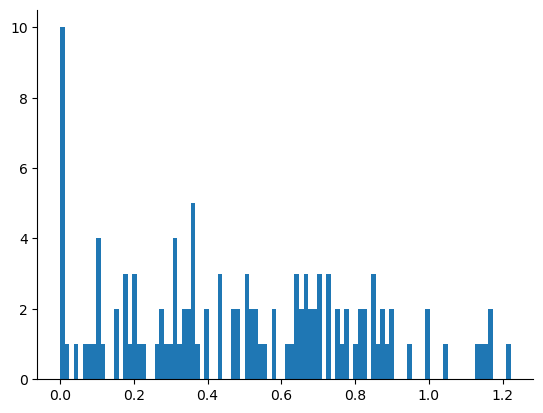

In [ ]:
plt.hist(unit_meta_df["ncsnr"], bins=100)
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# Assume your DataFrame is called df
# and has columns: "stimulus", "trial", "response".

# 1) Group by stimulus (image) and compute the mean response for each stimulus
grouped = df.groupby('stimulus')['response']
condition_means = grouped.mean()
# 2) Variance across condition means
#    (this is the "across-condition" variance, sigma_across^2)
variance_across = condition_means.var(ddof=1)  # sample variance across images
# 3) Variance within each condition
#    (variance of single-trial responses, for each stimulus)
within_vars = grouped.var(ddof=1)              # each image's single-trial variance
# 4) Average within-condition variance
#    (this is sigma_within^2)
variance_within = within_vars.mean()
# 5) Compute noise-corrected SNR
ncsnr = (variance_across - variance_within) / variance_within
print("Across-condition variance =", variance_across)
print("Average within-condition variance =", variance_within)
print("NC-SNR =", ncsnr)


### Large scale prediction experiment

In [5]:
import pandas as pd
def load_Hess_vector_data(stimuli_dir, space_names=("noise", "class")):
    df_both = []
    for space_name in space_names:
        data = np.load(join(stimuli_dir, "summary", f"{space_name}_ImDist_root_data.npz"))
        # Assuming data is already loaded as shown in the previous cells
        xtick_arr = data["xtick_arr"]
        dsim_arr = data["dsim_arr"]
        vecs_arr = data["vecs_arr"]
        eiglist = data["eiglist"]   
        targ_val = data["targ_val"]
        target_val_arr = [*(-targ_val[::-1]), 0, *targ_val]
        assert xtick_arr.shape[1] == len(target_val_arr)
        vecs_flattened = vecs_arr.reshape(-1, vecs_arr.shape[-1])
        # check the first 128 dimensions of vecs_flattened are close to each other
        share_mask = {"noise": slice(128, 256), "class": slice(0, 128)}[space_name]
        assert np.all(vecs_flattened[:, share_mask] == vecs_flattened[0:1, share_mask])
        # Create a DataFrame to organize the data into a table
        table_data = []
        for i in range(xtick_arr.shape[0]):
            for j in range(xtick_arr.shape[1]):
                row = {
                    "xtick_latent": xtick_arr[i, j],
                    "dsim_actual": dsim_arr[i, j],
                    "dsim_target": target_val_arr[j],
                    "eig_id": eiglist[i],
                    "space_name": space_name,
                    "vec": vecs_arr[i, j, :], # .tolist()
                }
                table_data.append(row)

        df = pd.DataFrame(table_data)
        df_both.append(df)
        print(f"{space_name} space data shape =", df.shape)
        # check the column of dsim_actual and dsim_target are close to each other
        print(f"{space_name} space maximal deviation of dsim_actual and dsim_target =", np.max(np.abs(df["dsim_actual"] - np.abs(df["dsim_target"]))))
        # assert np.allclose(df["dsim_actual"], np.abs(df["dsim_target"]), atol=5e-3)

    df_both = pd.concat(df_both)
    # df_both.to_csv(join(stimuli_dir, "summary", "Hess_ImDist_root_data.csv"), index=False)
    return df_both


In [6]:
df_both = load_Hess_vector_data(stimuli_dir)

noise space data shape = (81, 6)
noise space maximal deviation of dsim_actual and dsim_target = 0.00649564862251284
class space data shape = (90, 6)
class space maximal deviation of dsim_actual and dsim_target = 0.0009718310832977362


In [230]:
import xarray as xr
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from neuro_data_analysis.neural_data_utils import area_mapping, parse_meta, get_Animal_expdate
from neuro_data_analysis.neural_tuning_analysis_lib import organize_unit_info, maybe_add_unit_id_to_meta, \
    calculate_neural_responses, parse_stim_info, find_full_image_paths, load_space_images


# Define a function to fit RidgeCV and compute R2 scores
def fit_and_evaluate_ridge(X_train, X_test, y_train, y_test):
    ridge_cv = RidgeCV(alphas=np.logspace(-6, 6, 100), alpha_per_target=True, normalize=True).fit(X_train, y_train)
    y_train_pred = ridge_cv.predict(X_train)
    y_test_pred = ridge_cv.predict(X_test)
    train_r2 = r2_score(y_train, y_train_pred, multioutput="raw_values")
    test_r2 = r2_score(y_test, y_test_pred, multioutput="raw_values")
    return ridge_cv, train_r2, test_r2


for rowi, exprow in ExpRecord_Hessian_All.iterrows():
    if rowi < 18: #7
        continue
    print(exprow.ephysFN,exprow.Expi)
    Animal, expdate = get_Animal_expdate(exprow.ephysFN, exprow.expControlFN)
    data = pkl.load(open(join(pkl_root, f"{exprow.ephysFN}.pkl"), "rb"))
    rasters = data["rasters"]
    meta = data["meta"]
    Trials = data["Trials"]

    imageName = np.squeeze(Trials.imageName)
    stimuli_dir = exprow.stimuli
    stimuli_dir = stimuli_dir.replace("N:", "S:")
    # Process unit information
    meta = maybe_add_unit_id_to_meta(meta, rasters,) # for older experiments, unit_id is not in the meta file
    unit_info = organize_unit_info(meta, exprow)
    prefchan_id = unit_info["prefchan_id"]
    prefchan_str = unit_info["prefchan_str"]
    expstr = f"{exprow.ephysFN} | Pref Channel {prefchan_str}"
    
    
    # Process image names
    unique_imgnames = np.unique(imageName)
    stim_info_df = parse_stim_info(unique_imgnames)
    indices_per_name = {name: np.where(imageName == name)[0] for name in unique_imgnames}
    stim_info_df["trial_ids"] = stim_info_df.apply(lambda row: indices_per_name[row["img_name"]], axis=1)
    # uniq_img_fps = find_full_image_paths(stimuli_dir, unique_imgnames)
    resp_wdw = slice(50, 200)
    bsl_wdw = slice(0, 45)
    bsl_mat = rasters[:, bsl_wdw, :].mean(axis=1)
    resp_mat = rasters[:, resp_wdw, :].mean(axis=1) # average over time
    resp_mat_xr = xr.DataArray(resp_mat, dims = ('presentation', 'channel'), 
                            coords={'image_id': ('presentation', imageName), 
                                    "channel_id": ("channel", unit_info['channel_id']),
                                    "unit_id": ("channel", unit_info['unit_id']),
                                    "channel_name": ("channel", unit_info['unit_str']),})
    
    # Compute NCSNR for each channel
    unit_meta = []
    for chani in range(resp_mat.shape[1]):
        df = pd.DataFrame({"img_name": imageName, "unit_response": resp_mat[:, chani], "unit_baseline": bsl_mat[:, chani]})
        ncsnr = compute_ncsnr_from_df(df, stim_var_name="img_name", resp_var_name="unit_response")
        tval, pval = stats.ttest_rel(df["unit_response"], df["unit_baseline"])
        unit_meta.append({"chani": chani, "ncsnr": ncsnr, "tval": tval, "pval": pval})

    unit_snr_df = pd.DataFrame(unit_meta)
    
    df_latent = load_Hess_vector_data(stimuli_dir)
    stim_info_latentvec_df = pd.merge(stim_info_df, df_latent, left_on=["space_name", "eig_id", "lin_dist"], right_on=["space_name", "eig_id", "dsim_target"], how="left")
    # make the image dataset
    avg_resp_mat_xr = resp_mat_xr.groupby('image_id').mean()
    avg_resp_mat_xr = avg_resp_mat_xr.sel(image_id=stim_info_latentvec_df['img_name'].values)
    assert np.all(avg_resp_mat_xr["image_id"].values == stim_info_latentvec_df["img_name"].values)
    latent_vecs = np.stack(stim_info_latentvec_df["vec"].values)
    print(avg_resp_mat_xr.shape)
    print(latent_vecs.shape)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(latent_vecs[:, :], avg_resp_mat_xr, test_size=0.2, random_state=42)

    # Fit models and compute R2 scores for full, class, and noise data
    ridge_cv, train_r2_per_channel, test_r2_per_channel = fit_and_evaluate_ridge(X_train, X_test, y_train, y_test)
    ridge_cv_class, train_r2_per_channel_class, test_r2_per_channel_class = fit_and_evaluate_ridge(X_train[:, :128], X_test[:, :128], y_train, y_test)
    ridge_cv_noise, train_r2_per_channel_noise, test_r2_per_channel_noise = fit_and_evaluate_ridge(X_train[:, 128:], X_test[:, 128:], y_train, y_test)

    # Create DataFrame with R2 scores and additional information
    unit_r2_df = pd.DataFrame({
        "train_r2": train_r2_per_channel, 
        "test_r2": test_r2_per_channel, 
        "train_r2_class": train_r2_per_channel_class, 
        "test_r2_class": test_r2_per_channel_class,
        "train_r2_noise": train_r2_per_channel_noise, 
        "test_r2_noise": test_r2_per_channel_noise,
        "ncsnr": unit_snr_df["ncsnr"], 
        "tval": unit_snr_df["tval"], 
        "pval": unit_snr_df["pval"], 
        "channel_id": unit_info["channel_id"], 
        "unit_id": unit_info["unit_id"], 
        "channel_name": unit_info["unit_str"]
    })
    unit_r2_df["area"] = unit_r2_df["channel_id"].apply(lambda x: area_mapping(x, Animal, expdate))
    min_trials = min(stim_info_df["trial_ids"].apply(lambda x: len(x)))
    print(min_trials)
    unit_r2_df["noise_ceiling"] = unit_r2_df["ncsnr"].apply(lambda x: (np.power(x,2) / (np.power(x,2)+(1/min_trials))))
    for col in ["train_r2", "test_r2", "train_r2_class", "test_r2_class", "train_r2_noise", "test_r2_noise"]:
        unit_r2_df[col+"_nc_normed"] = unit_r2_df[col] / unit_r2_df["noise_ceiling"]
    unit_r2_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    display(unit_r2_df.query("pval < 0.01").groupby("area").agg(
        {"train_r2": "mean", "test_r2": "mean", 
        "train_r2_class": "mean", "test_r2_class": "mean", 
        "train_r2_noise": "mean", "test_r2_noise": "mean", "ncsnr": ["mean", "count"]}
        ).loc[["V1", "V4", "IT"]])

    display(unit_r2_df.query("pval < 0.01").groupby("area").agg(
        {"train_r2_nc_normed": "mean", "test_r2_nc_normed": "mean", 
        "train_r2_class_nc_normed": "mean", "test_r2_class_nc_normed": "mean", 
        "train_r2_noise_nc_normed": "mean", "test_r2_noise_nc_normed": "mean", "noise_ceiling": "mean", "ncsnr": ["mean", "count"]}
        ).loc[["V1", "V4", "IT"]])
    # stimuli_dataset = ImagePathDataset(list(uniq_img_fps.values()), scores=None, img_dim=(256, 256))

    # # Calculate responses
    # resp_info = calculate_neural_responses(rasters, prefchan_id)
    # prefchan_resp_sgtr = resp_info["prefchan_resp_sgtr"]
    # # prefchan_bsl_mean = resp_info["prefchan_bsl_mean"]
    # # prefchan_bsl_sem = resp_info["prefchan_bsl_sem"]
    
    # # Create response dataframe
    # sgtr_popresp_df = pd.DataFrame({"img_name": imageName, "pref_unit_resp": prefchan_resp_sgtr[:, 0]})
    # # annotate the response dataframe with the stimulus information by merging on the image name
    # sgtr_popresp_df = sgtr_popresp_df.merge(stim_info_df.drop(columns=['trial_ids']), on="img_name")
    # # compute the average response per space and eigenvector
    # pref_avgresp_df = sgtr_popresp_df.groupby(['space_name', 'eig_id', 'lin_dist']).agg({'pref_unit_resp': 'mean'}).reset_index()
    # pref_avg_resp_class = pref_avgresp_df.query(f"space_name == 'class'")
    # pref_avg_resp_noise = pref_avgresp_df.query(f"space_name == 'noise'")
    # pref_avg_resp_noise_mat = pref_avg_resp_noise.pivot(index='eig_id', columns='lin_dist', values='pref_unit_resp')
    # pref_avg_resp_class_mat = pref_avg_resp_class.pivot(index='eig_id', columns='lin_dist', values='pref_unit_resp')
    break 

Alfa-27082020-003 6.0
Exist inactive channels: [ 1 20]
 firing rate [0.        1.0922855]
noise space data shape = (108, 6)
noise space maximal deviation of dsim_actual and dsim_target = 0.0004887056350708074
class space data shape = (117, 6)
class space maximal deviation of dsim_actual and dsim_target = 0.00048229813575745295
(225, 80)
(225, 256)
7


train_r2   test_r2 train_r2_class test_r2_class train_r2_noise test_r2_noise     ncsnr      
          mean      mean           mean          mean           mean          mean      mean count
area                                                                                              
V1    0.180743 -0.179602       0.092756     -0.247854       0.119398     -0.172879  0.666010    19
V4    0.253987 -0.189306       0.151012     -0.271151       0.117697     -0.080783  0.777993    22
IT    0.168417 -0.014575       0.113433     -0.041431       0.061186     -0.005316  0.448882    38

train_r2_nc_normed test_r2_nc_normed train_r2_class_nc_normed test_r2_class_nc_normed train_r2_noise_nc_normed test_r2_noise_nc_normed noise_ceiling     ncsnr      
                   mean              mean                     mean                    mean                     mean                    mean          mean      mean count
area                                                                                                                                                                     
V1             0.240424         -0.249736                 0.120035               -0.336565                 0.174439               -0.242215      0.688289  0.666010    19
V4             0.319376         -0.223891                 0.188809               -0.326695                 0.148793               -0.096590      0.798350  0.777993    22
IT             0.387407         -0.072228                 0.261755               -0.107145                 0.132494               -0.053968      0.525076  0.448882    38

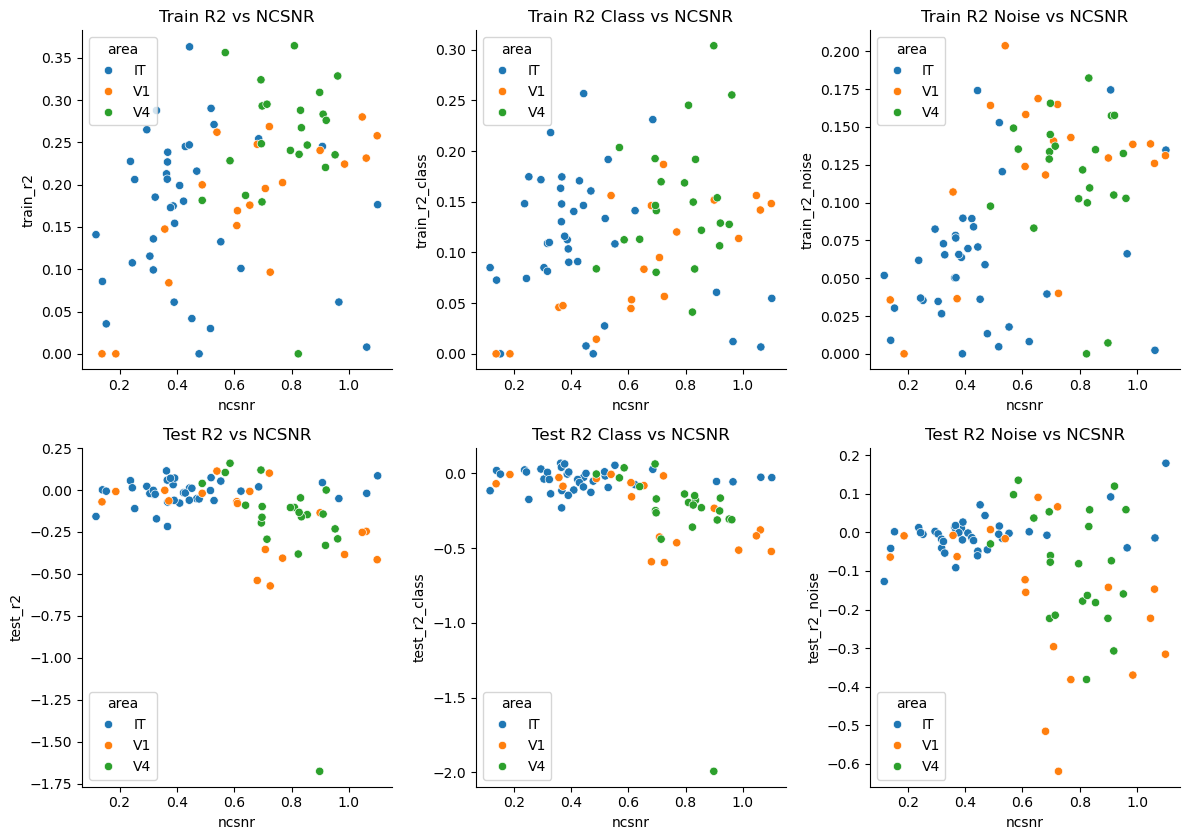

In [231]:
fig, axes = plt.subplots(2, 3, figsize=(12.0, 8.5))
metrics = ["train_r2", "test_r2", "train_r2_class", "test_r2_class", "train_r2_noise", "test_r2_noise"]
titles = ["Train R2 vs NCSNR", "Test R2 vs NCSNR", "Train R2 Class vs NCSNR", 
          "Test R2 Class vs NCSNR", "Train R2 Noise vs NCSNR", "Test R2 Noise vs NCSNR"]

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    row, col = divmod(idx, 2)
    sns.scatterplot(data=unit_r2_df, x="ncsnr", y=metric, hue="area", ax=axes[col, row])
    axes[col, row].set_title(title)

plt.tight_layout()
plt.show()

In [191]:
min_trials = min(stim_info_df["trial_ids"].apply(lambda x: len(x)))
print(min_trials)
unit_r2_df["noise_ceiling"] = unit_r2_df["ncsnr"].apply(lambda x: (np.power(x,2) / (np.power(x,2)+(1/min_trials))))
for col in ["train_r2", "test_r2", "train_r2_class", "test_r2_class", "train_r2_noise", "test_r2_noise"]:
    unit_r2_df[col+"_nc_normed"] = unit_r2_df[col] / unit_r2_df["noise_ceiling"]
unit_r2_df.replace([np.inf, -np.inf], np.nan, inplace=True)
unit_r2_df

6


,train_r2,test_r2,train_r2_class,test_r2_class,train_r2_noise,test_r2_noise,ncsnr,tval,pval,channel_id,unit_id,channel_name,area,noise_ceiling,train_r2_nc_normed,test_r2_nc_normed,train_r2_class_nc_normed,test_r2_class_nc_normed,train_r2_noise_nc_normed,test_r2_noise_nc_normed
0,6.907160e-07,0.000000,6.850060e-07,0.000000,4.738352e-09,0.000000,0.000000,1.000000,3.175037e-01,1,0,1U,IT,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,1.842043e-01,-0.146958,1.124015e-01,-0.099585,6.698361e-02,-0.048295,0.034294,36.713710,6.810744e-201,1,1,1A,IT,0.007007,26.288424,-20.972923,16.041198,-14.212123,9.559461e+00,-6.892290
2,9.345127e-07,0.000000,3.135583e-07,0.000000,2.160669e-04,0.000000,0.000000,1.891766,5.875276e-02,2,0,2U,IT,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,1.763418e-01,0.009574,1.696209e-06,-0.012967,1.196068e-01,-0.073353,0.324442,71.814870,0.000000e+00,2,1,2A,IT,0.387095,0.455552,0.024734,0.000004,-0.033499,3.089857e-01,-0.189495
4,1.000000e+00,-0.025000,1.000000e+00,-0.025000,1.000000e+00,-0.025000,0.000000,1.000000,3.175037e-01,3,0,3U,IT,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
5,1.097056e-01,-0.026176,1.100151e-01,-0.009165,2.425093e-02,-0.020133,0.051235,19.153155,6.491263e-72,3,1,3A,IT,0.015506,7.075089,-1.688148,7.095047,-0.591092,1.563981e+00,-1.298387
6,4.852083e-02,-0.046796,1.170733e-06,-0.003852,6.066581e-02,-0.108426,0.066575,2.423487,1.551331e-02,4,1,4A,IT,0.025904,1.873071,-1.806490,0.000045,-0.148686,2.341909e+00,-4.185631
7,1.263883e-03,-0.046811,1.344151e-06,-0.046804,5.495912e-03,-0.046985,0.000000,-0.166843,8.675206e-01,5,0,5U,IT,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
8,1.059047e-01,-0.047609,9.515122e-02,-0.088646,1.968343e-02,-0.001368,0.000000,2.159694,3.098576e-02,5,1,5A,IT,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
9,1.930618e-06,-0.008210,1.343336e-06,-0.008210,5.905292e-07,-0.008211,0.000000,6.381608,2.462004e-10,6,0,6U,IT,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [193]:
display(unit_r2_df.query("pval < 0.05").groupby("area").agg(
        {"train_r2_nc_normed": "mean", "test_r2_nc_normed": "mean", 
        "train_r2_class_nc_normed": "mean", "test_r2_class_nc_normed": "mean", 
        "train_r2_noise_nc_normed": "mean", "test_r2_noise_nc_normed": "mean", "noise_ceiling": "mean", "ncsnr": ["mean", "count"]}
        ).loc[["V1", "V4", "IT"]])


train_r2_nc_normed test_r2_nc_normed train_r2_class_nc_normed test_r2_class_nc_normed train_r2_noise_nc_normed test_r2_noise_nc_normed noise_ceiling     ncsnr      
                   mean              mean                     mean                    mean                     mean                    mean          mean      mean count
area                                                                                                                                                                     
V1             0.658548          0.060985                 0.440018               -0.034144                 0.233424               -0.010343      0.609604  0.682622    21
V4             0.415967         -0.385170                 0.268155               -0.316707                 0.193750               -0.477742      0.590510  0.621504    25
IT             1.610102         -1.002329                 0.968588               -0.607224                 0.801815               -0.668600      0.278492  0.278061    39

In [181]:
display(unit_r2_df.query("pval < 0.05").groupby("area").agg(
        {"train_r2": "mean", "test_r2": "mean", 
        "train_r2_class": "mean", "test_r2_class": "mean", 
        "train_r2_noise": "mean", "test_r2_noise": "mean", "ncsnr": ["mean", "count"]}
        ).loc[["V1", "V4", "IT"]])

train_r2   test_r2 train_r2_class test_r2_class train_r2_noise test_r2_noise     ncsnr      
          mean      mean           mean          mean           mean          mean      mean count
area                                                                                              
V1    0.158531 -0.013949       0.156976     -0.039853       0.008969     -0.020629  0.682622    21
V4    0.150518 -0.031332       0.128456     -0.060011       0.040320     -0.016171  0.621504    25
IT    0.129717 -0.030203       0.080218     -0.028237       0.056202     -0.032940  0.278061    39

In [154]:
unit_meta = []
for chani in range(resp_mat.shape[1]):
    df = pd.DataFrame({"img_name": imageName, "unit_response": resp_mat[:, chani], "unit_baseline": bsl_mat[:, chani]})
    ncsnr = compute_ncsnr_from_df(df, stim_var_name="img_name", resp_var_name="unit_response")
    tval, pval = stats.ttest_rel(df["unit_response"], df["unit_baseline"])
    unit_meta.append({"chani": chani, "ncsnr": ncsnr, "tval": tval, "pval": pval})
    # print(f"Channel {chani} NC-SNR = {ncsnr:3f} tval = {tval:.2f} pval = {pval:.2f}")


unit_snr_df = pd.DataFrame(unit_meta)

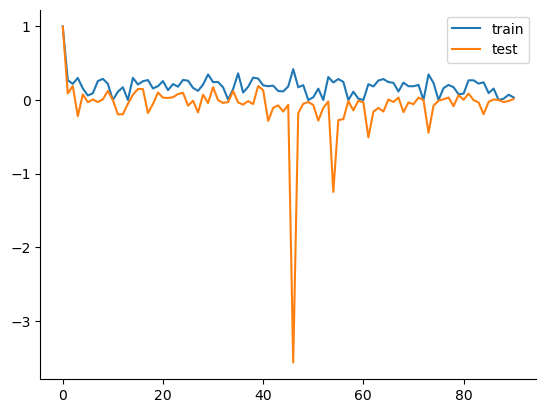

In [159]:

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(latent_vecs[:, :], avg_resp_mat_xr, test_size=0.2, random_state=42)

# Define a function to fit RidgeCV and compute R2 scores
def fit_and_evaluate_ridge(X_train, X_test, y_train, y_test):
    ridge_cv = RidgeCV(alphas=np.logspace(-6, 6, 100), alpha_per_target=True, normalize=True).fit(X_train, y_train)
    y_train_pred = ridge_cv.predict(X_train)
    y_test_pred = ridge_cv.predict(X_test)
    train_r2 = r2_score(y_train, y_train_pred, multioutput="raw_values")
    test_r2 = r2_score(y_test, y_test_pred, multioutput="raw_values")
    return ridge_cv, train_r2, test_r2

# Fit models and compute R2 scores for full, class, and noise data
ridge_cv, train_r2_per_channel, test_r2_per_channel = fit_and_evaluate_ridge(X_train, X_test, y_train, y_test)
ridge_cv_class, train_r2_per_channel_class, test_r2_per_channel_class = fit_and_evaluate_ridge(X_train[:, :128], X_test[:, :128], y_train, y_test)
ridge_cv_noise, train_r2_per_channel_noise, test_r2_per_channel_noise = fit_and_evaluate_ridge(X_train[:, 128:], X_test[:, 128:], y_train, y_test)

# Create DataFrame with R2 scores and additional information
unit_r2_df = pd.DataFrame({
    "train_r2": train_r2_per_channel, 
    "test_r2": test_r2_per_channel, 
    "train_r2_class": train_r2_per_channel_class, 
    "test_r2_class": test_r2_per_channel_class,
    "train_r2_noise": train_r2_per_channel_noise, 
    "test_r2_noise": test_r2_per_channel_noise,
    "ncsnr": unit_snr_df["ncsnr"], 
    "tval": unit_snr_df["tval"], 
    "pval": unit_snr_df["pval"], 
    "channel_id": unit_info["channel_id"], 
    "unit_id": unit_info["unit_id"], 
    "channel_name": unit_info["unit_str"]
})

plt.plot(train_r2_per_channel, label="train")
plt.plot(test_r2_per_channel, label="test")
plt.legend()
plt.show()

In [160]:
from neuro_data_analysis.neural_data_utils import area_mapping, parse_meta, get_Animal_expdate
from neuro_data_analysis.neural_tuning_analysis_lib import organize_unit_info, maybe_add_unit_id_to_meta, \
    calculate_neural_responses, parse_stim_info, find_full_image_paths, load_space_images
# area_mapping
Animal, expdate = get_Animal_expdate(exprow.ephysFN, exprow.expControlFN)

In [161]:
Animal, expdate = get_Animal_expdate(exprow.ephysFN, exprow.expControlFN)
unit_r2_df["area"] = unit_r2_df["channel_id"].apply(lambda x: area_mapping(x, Animal, expdate))

In [162]:
unit_r2_df.groupby("area").agg(
    {"train_r2": "mean", "test_r2": "mean", 
    "train_r2_class": "mean", "test_r2_class": "mean", 
    "train_r2_noise": "mean", "test_r2_noise": "mean"}
    ).loc[["V1", "V4", "IT"]]

,train_r2,test_r2,train_r2_class,test_r2_class,train_r2_noise,test_r2_noise
area,,,,,,
V1,0.170809,-0.304139,0.115047,-0.294600,0.059140,-0.102937
V4,0.149929,-0.036193,0.089019,-0.081709,0.071385,0.036340
IT,0.218904,0.035752,0.112858,0.011927,0.149038,-0.055466


In [167]:
unit_r2_df.query("pval < 0.001").groupby("area").agg(
    {"train_r2": "mean", "test_r2": "mean", 
    "train_r2_class": "mean", "test_r2_class": "mean", 
    "train_r2_noise": "mean", "test_r2_noise": "mean", "ncsnr": ["mean", "count"]}
    ).loc[["V1", "V4", "IT"]]

train_r2   test_r2 train_r2_class test_r2_class train_r2_noise test_r2_noise     ncsnr      
          mean      mean           mean          mean           mean          mean      mean count
area                                                                                              
V1    0.200975 -0.352339       0.134810     -0.341430       0.067971     -0.113186  0.509081    22
V4    0.156447 -0.037767       0.092889     -0.085261       0.074295      0.037920  0.539569    23
IT    0.209870  0.013618       0.095452     -0.012088       0.134407     -0.084802  0.467355    38

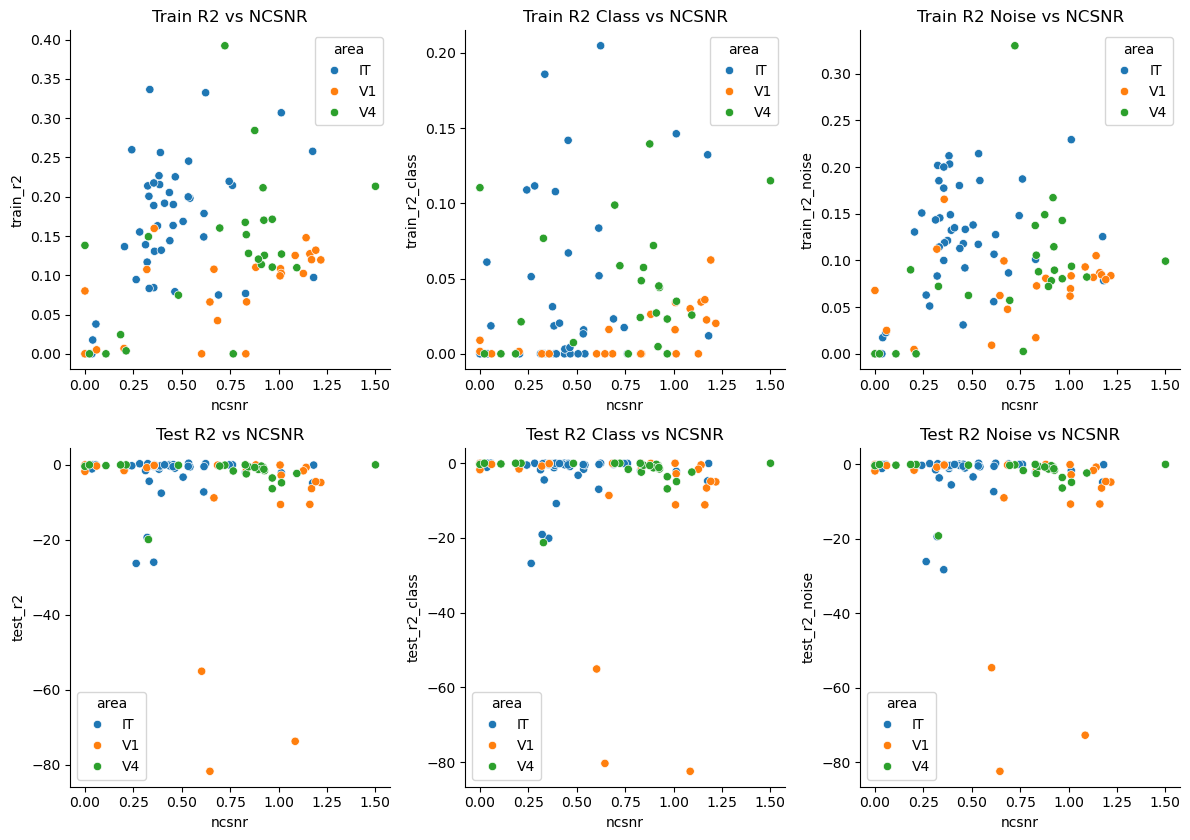

In [144]:
fig, axes = plt.subplots(2, 3, figsize=(12.0, 8.5))
metrics = ["train_r2", "test_r2", "train_r2_class", "test_r2_class", "train_r2_noise", "test_r2_noise"]
titles = ["Train R2 vs NCSNR", "Test R2 vs NCSNR", "Train R2 Class vs NCSNR", 
          "Test R2 Class vs NCSNR", "Train R2 Noise vs NCSNR", "Test R2 Noise vs NCSNR"]

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    row, col = divmod(idx, 2)
    sns.scatterplot(data=unit_r2_df, x="ncsnr", y=metric, hue="area", ax=axes[col, row])
    axes[col, row].set_title(title)

plt.tight_layout()
plt.show()

#### Scratch

In [7]:
import xarray as xr

In [13]:
resp_wdw = slice(50, 200)
bsl_wdw = slice(0, 45)
bsl_mat = rasters[:, bsl_wdw, :].mean(axis=1)
resp_mat = rasters[:, resp_wdw, :].mean(axis=1) # average over time
resp_mat_xr = xr.DataArray(resp_mat, dims = ('presentation', 'channel'), 
                           coords={'image_id': ('presentation', imageName), 
                                "channel_id": ("channel", unit_info['channel_id']),
                                "unit_id": ("channel", unit_info['unit_id']),
                                "channel_name": ("channel", unit_info['unit_str']),})


In [ ]:
resp_mat_xr["image_id"]

In [30]:
def generate_new_coords(image_id):
    # Example function to generate new coordinates based on image_id
    return [f"coord_{i}" for i in range(len(image_id))]

stim_info_df_expanded = pd.merge(pd.DataFrame({"img_name": imageName}), stim_info_df.drop(columns=["trial_ids"]), on="img_name", how="left")
resp_mat_xr = resp_mat_xr.assign_coords(space_name=("presentation", stim_info_df_expanded["space_name"]),
                                        eig_id=("presentation", stim_info_df_expanded["eig_id"]),
                                        lin_dist=("presentation", stim_info_df_expanded["lin_dist"]))

In [38]:
avg_resp_mat_xr = resp_mat_xr.groupby('image_id').mean()
avg_resp_mat_xr = avg_resp_mat_xr.sel(image_id=stim_info_df['img_name'].values)
avg_resp_mat_xr

<xarray.DataArray (image_id: 81, channel: 120)> Size: 39kB
array([[ 75.59147  ,  91.42625  ,  14.50353  , ...,  49.702866 ,
         67.88926  ,   1.4799643],
       [ 95.24776  ,  81.87891  ,  16.830837 , ...,  71.96593  ,
         90.39883  ,   0.7399821],
       [ 93.32906  ,  89.32953  ,  13.955431 , ...,  69.377365 ,
         65.11599  ,   2.221588 ],
       ...,
       [100.168144 , 106.48702  ,  18.826447 , ...,  44.718666 ,
         65.84466  ,   1.9979519],
       [109.78137  , 122.41968  ,  14.426778 , ...,  49.806602 ,
         75.710556 ,   0.6659839],
       [105.91229  , 109.53999  ,  19.236248 , ...,  46.842052 ,
         73.37544  ,   4.6618876]], dtype=float32)
Coordinates:
    channel_id    (channel) int32 480B 1 2 3 3 4 4 5 6 ... 92 93 93 93 94 95 96
    unit_id       (channel) int32 480B 1 1 1 2 1 2 1 1 1 2 ... 2 1 2 1 2 3 1 1 1
    channel_name  (channel) <U3 1kB '1A' '2A' '3A' '3B' ... '94A' '95A' '96A'
  * image_id      (image_id) object 648B 'noise_eig0_lin-0.16' ... 'noise_eig...
Dimensions without coordinates: channel

In [41]:
df_latent = load_Hess_vector_data(stimuli_dir)

noise space data shape = (81, 6)
noise space maximal deviation of dsim_actual and dsim_target = 0.00649564862251284
class space data shape = (90, 6)
class space maximal deviation of dsim_actual and dsim_target = 0.0009718310832977362


In [45]:
stim_info_latentvec_df = pd.merge(stim_info_df, df_latent, left_on=["space_name", "eig_id", "lin_dist"], right_on=["space_name", "eig_id", "dsim_target"], how="left")

In [39]:
avg_resp_mat_xr["image_id"]

<xarray.DataArray 'image_id' (image_id: 81)> Size: 648B
array(['noise_eig0_lin-0.16', 'noise_eig0_lin-0.24', 'noise_eig0_lin-0.32',
       'noise_eig0_lin-0.40', 'noise_eig0_lin0.00', 'noise_eig0_lin0.16',
       'noise_eig0_lin0.24', 'noise_eig0_lin0.32', 'noise_eig0_lin0.40',
       'noise_eig10_lin-0.16', 'noise_eig10_lin-0.24', 'noise_eig10_lin-0.32',
       'noise_eig10_lin-0.40', 'noise_eig10_lin0.00', 'noise_eig10_lin0.16',
       'noise_eig10_lin0.24', 'noise_eig10_lin0.32', 'noise_eig10_lin0.40',
       'noise_eig1_lin-0.16', 'noise_eig1_lin-0.24', 'noise_eig1_lin-0.32',
       'noise_eig1_lin-0.40', 'noise_eig1_lin0.00', 'noise_eig1_lin0.16',
       'noise_eig1_lin0.24', 'noise_eig1_lin0.32', 'noise_eig1_lin0.40',
       'noise_eig20_lin-0.16', 'noise_eig20_lin-0.24', 'noise_eig20_lin-0.32',
       'noise_eig20_lin-0.40', 'noise_eig20_lin0.00', 'noise_eig20_lin0.16',
       'noise_eig20_lin0.24', 'noise_eig20_lin0.32', 'noise_eig20_lin0.40',
       'noise_eig2_lin-0.16', 'noise_eig2_lin-0.24', 'noise_eig2_lin-0.32',
       'noise_eig2_lin-0.40', 'noise_eig2_lin0.00', 'noise_eig2_lin0.16',
       'noise_eig2_lin0.24', 'noise_eig2_lin0.32', 'noise_eig2_lin0.40',
       'noise_eig3_lin-0.16', 'noise_eig3_lin-0.24', 'noise_eig3_lin-0.32',
       'noise_eig3_lin-0.40', 'noise_eig3_lin0.00', 'noise_eig3_lin0.16',
       'noise_eig3_lin0.24', 'noise_eig3_lin0.32', 'noise_eig3_lin0.40',
       'noise_eig40_lin-0.16', 'noise_eig40_lin-0.24', 'noise_eig40_lin-0.32',
       'noise_eig40_lin-0.40', 'noise_eig40_lin0.00', 'noise_eig40_lin0.16',
       'noise_eig40_lin0.24', 'noise_eig40_lin0.32', 'noise_eig40_lin0.40',
       'noise_eig5_lin-0.16', 'noise_eig5_lin-0.24', 'noise_eig5_lin-0.32',
       'noise_eig5_lin-0.40', 'noise_eig5_lin0.00', 'noise_eig5_lin0.16',
       'noise_eig5_lin0.24', 'noise_eig5_lin0.32', 'noise_eig5_lin0.40',
       'noise_eig8_lin-0.16', 'noise_eig8_lin-0.24', 'noise_eig8_lin-0.32',
       'noise_eig8_lin-0.40', 'noise_eig8_lin0.00', 'noise_eig8_lin0.16',
       'noise_eig8_lin0.24', 'noise_eig8_lin0.32', 'noise_eig8_lin0.40'],
      dtype=object)
Coordinates:
  * image_id  (image_id) object 648B 'noise_eig0_lin-0.16' ... 'noise_eig8_li...

In [63]:
avg_resp_mat_xr = resp_mat_xr.groupby('image_id').mean()
avg_resp_mat_xr = avg_resp_mat_xr.sel(image_id=stim_info_latentvec_df['img_name'].values)
assert np.all(avg_resp_mat_xr["image_id"].values == stim_info_latentvec_df["img_name"].values)
latent_vecs = np.stack(stim_info_latentvec_df["vec"].values)
print(avg_resp_mat_xr.shape)
print(latent_vecs.shape)
avg_resp_mat_xr


(81, 120)
(81, 256)


<xarray.DataArray (image_id: 81, channel: 120)> Size: 39kB
array([[ 75.59147  ,  91.42625  ,  14.50353  , ...,  49.702866 ,
         67.88926  ,   1.4799643],
       [ 95.24776  ,  81.87891  ,  16.830837 , ...,  71.96593  ,
         90.39883  ,   0.7399821],
       [ 93.32906  ,  89.32953  ,  13.955431 , ...,  69.377365 ,
         65.11599  ,   2.221588 ],
       ...,
       [100.168144 , 106.48702  ,  18.826447 , ...,  44.718666 ,
         65.84466  ,   1.9979519],
       [109.78137  , 122.41968  ,  14.426778 , ...,  49.806602 ,
         75.710556 ,   0.6659839],
       [105.91229  , 109.53999  ,  19.236248 , ...,  46.842052 ,
         73.37544  ,   4.6618876]], dtype=float32)
Coordinates:
    channel_id    (channel) int32 480B 1 2 3 3 4 4 5 6 ... 92 93 93 93 94 95 96
    unit_id       (channel) int32 480B 1 1 1 2 1 2 1 1 1 2 ... 2 1 2 1 2 3 1 1 1
    channel_name  (channel) <U3 1kB '1A' '2A' '3A' '3B' ... '94A' '95A' '96A'
  * image_id      (image_id) object 648B 'noise_eig0_lin-0.16' ... 'noise_eig...
Dimensions without coordinates: channel

In [73]:
# perform linear regression of avg_resp_mat_xr on latent_vecs, ridgecv
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(latent_vecs[:, 128:], avg_resp_mat_xr, test_size=0.3, random_state=42)
# Initialize RidgeCV with cross-validation
ridge_cv = RidgeCV(alphas=np.logspace(-3, 3, 100), alpha_per_target=True)
# Fit the model
ridge_cv.fit(X_train, y_train)
# Predict on the test set
y_train_pred = ridge_cv.predict(X_train)
y_test_pred = ridge_cv.predict(X_test)
# compute R2 per channel
train_r2_per_channel = r2_score(y_train, y_train_pred, multioutput="raw_values")
test_r2_per_channel = r2_score(y_test, y_test_pred, multioutput="raw_values")

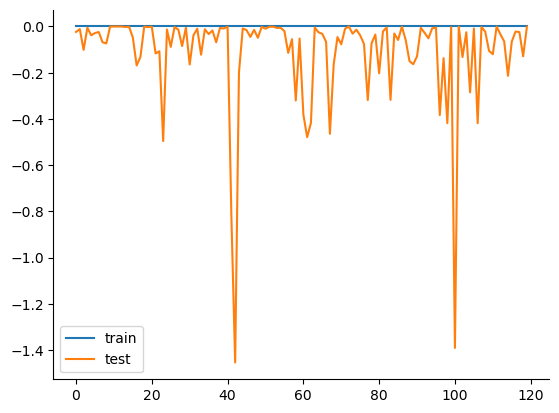

In [74]:
plt.plot(train_r2_per_channel, label="train")
plt.plot(test_r2_per_channel, label="test")
plt.legend()
plt.show()

### Meta analysis